Homomorphic 2‑D convolution demo
================================

Steps
-----
1. Load a grayscale image.
2. Build a simple smoothing filter (5×5 mean‑blur).
3. Show the image and the filter.
4. Encrypt image & filter, then visualise the ciphertext coefficients
   as greyscale grids.
5. Perform homomorphic convolution.
6. Visualise the ciphertext of the result.
7. Decrypt and display the filtered image.
8. Confirm it matches a clear‑text convolution.

In [1]:
# --- imports -----------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from collections.abc import Iterable
from IPython.display import display
from FourierCKKS import FourierCKKS
from util.ciphertext import Ciphertext       
from fft.fft import linear_convolution2d_direct     

In [2]:
# -----------------------------------------------------------------------------|
# helper: flatten ciphertext(s) → 1‑D numpy array                               |
# -----------------------------------------------------------------------------|
def _ct_to_array(ct: Ciphertext) -> np.ndarray:
    def poly_to_arr(poly):
        try:
            coeffs = np.asarray(poly.coeffs)
        except AttributeError:
            coeffs = np.asarray(poly)
        return np.real_if_close(coeffs).ravel()
    return np.concatenate([poly_to_arr(ct.c0), poly_to_arr(ct.c1)])

def flatten_ct(container) -> np.ndarray:
    if isinstance(container, Ciphertext):
        return _ct_to_array(container)
    if isinstance(container, Iterable):
        parts = [flatten_ct(item) for item in container]
        return np.concatenate(parts) if parts else np.array([], dtype=float)
    raise TypeError(f"Unsupported element inside container: {type(container)}")

# helper: shape a 1‑D vector into a near‑square 2‑D grid for imshow ------------
def to_grid(vec: np.ndarray) -> np.ndarray:
    """
    Turn an arbitrary‑length 1‑D vector of (possibly enormous) numbers into a
    float64 greyscale image suitable for plt.imshow.  Uses log‑magnitude so the
    picture isn't just black/white when values vary wildly.
    """
    n = vec.size
    h = int(np.floor(np.sqrt(n)))
    w = int(np.ceil(n / h))

    # Pad to h*w so reshape works
    grid = np.pad(vec, (0, h * w - n)).reshape(h, w)

    # Magnitude → log space, cast to float64 to prevent OverflowError
    grid = np.log1p(np.abs(grid).astype(np.float64))

    # Normalise to 0‑1 for display
    gmin, gmax = grid.min(), grid.max()
    rng = gmax - gmin
    if rng > 0:
        grid = (grid - gmin) / rng
    return grid


# 1) load an image (grayscale & float in [0,1])

In [3]:
img_path = "images/1.jpg"

# open → convert to grayscale → resize to 50×50
img = (Image.open(img_path)
              .convert("L")
              .resize((50, 50), Image.BILINEAR))

img_arr = np.asarray(img, dtype=float) / 255.0     # normalise to [0,1]
h_img, w_img = img_arr.shape
print(f"Loaded image {w_img}×{h_img}")


Loaded image 50×50


# 2) create a 5×5 mean‑blur filter

In [4]:
smoothing = True

In [5]:
if smoothing:
    filter_sz = 5
    flt = np.ones((filter_sz, filter_sz), dtype=float) / (filter_sz**2)

    # output size for linear convolution
    out_h, out_w = h_img + filter_sz - 1, w_img + filter_sz - 1
else:
    filter_sz = 5
    # 5×5 Laplacian filter
    flt = np.array([
        [ 0,  0, -1,  0,  0],
        [ 0, -1, -2, -1,  0],
        [-1, -2, 16, -2, -1],
        [ 0, -1, -2, -1,  0],
        [ 0,  0, -1,  0,  0]
    ], dtype=float)
    # output size for linear convolution
    out_h = h_img + filter_sz - 1
    out_w = w_img + filter_sz - 1

# 3) show image + filter

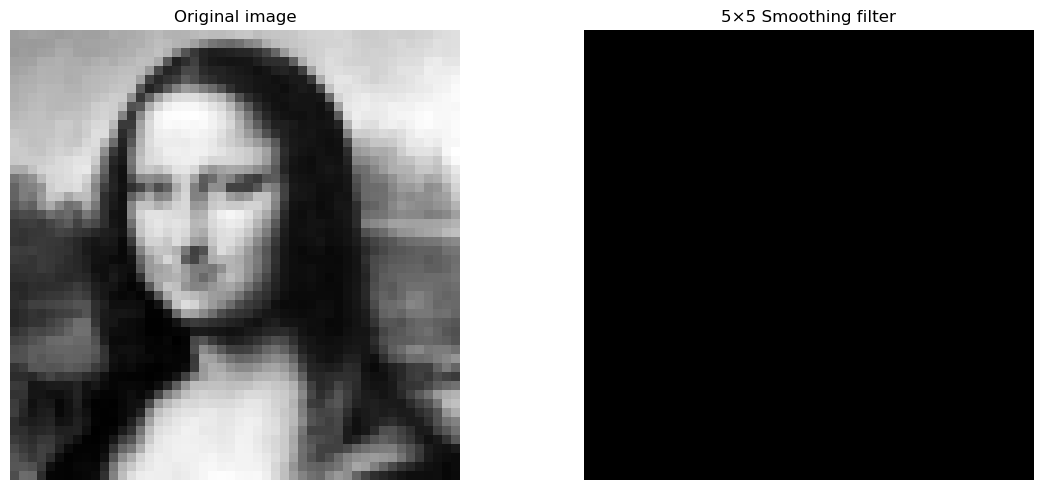

In [6]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(img_arr, cmap="gray")
plt.title("Original image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(flt, cmap="gray")
plt.title(f"{filter_sz}×{filter_sz} Smoothing filter")
plt.axis("off")

plt.tight_layout()
plt.show()

# 4) encrypt image and filter

PARALLEL!!!!!!


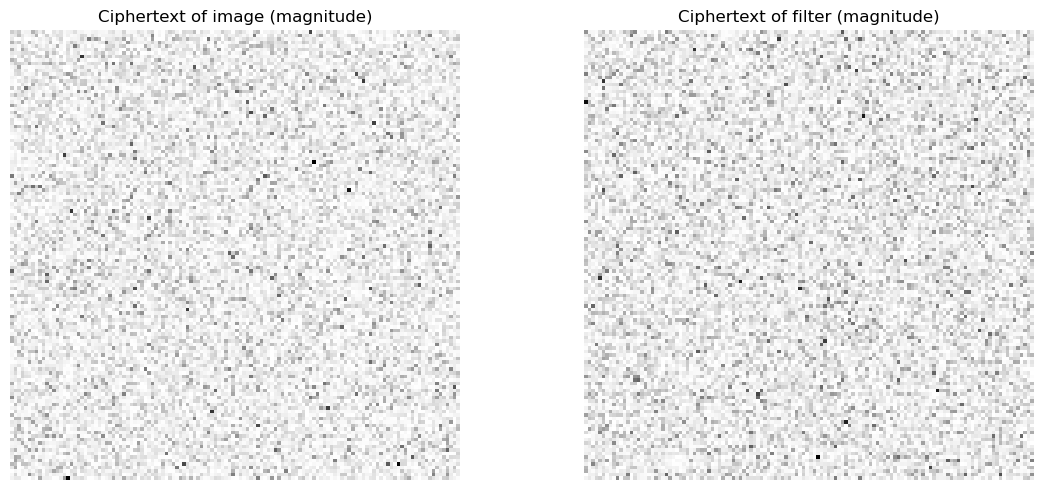

In [7]:
fcks = FourierCKKS(is_parallel=False)

ct_img = fcks.forward(img_arr, target_height=out_h, target_width=out_w)
ct_flt = fcks.forward(flt,     target_height=out_h, target_width=out_w)

# visualise ciphertext coefficients -------------------------------------------
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(to_grid(flatten_ct(ct_img)), cmap="gray")
plt.title("Ciphertext of image (magnitude)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(to_grid(flatten_ct(ct_flt)), cmap="gray")
plt.title("Ciphertext of filter (magnitude)")
plt.axis("off")

plt.tight_layout()
plt.show()

# 5) homomorphic convolution

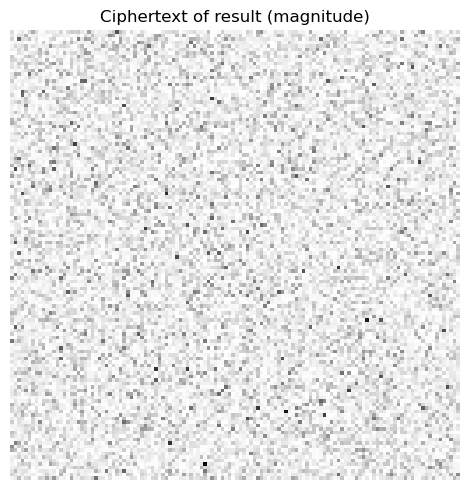

In [8]:
ct_conv = fcks.cipher_conv(ct_img, ct_flt)

plt.figure(figsize=(6, 5))
plt.imshow(to_grid(flatten_ct(ct_conv)), cmap="gray")
plt.title("Ciphertext of result (magnitude)")
plt.axis("off")
plt.tight_layout()
plt.show()

# 6) decrypt and display the filtered image

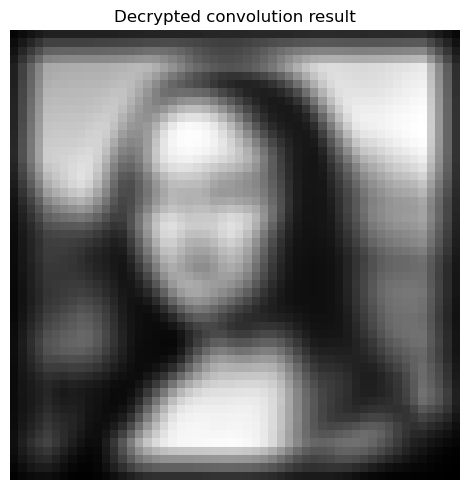

In [9]:
dec_conv = fcks.backward(ct_conv, target_height=out_h, target_width=out_w).real

plt.figure(figsize=(6, 5))
plt.imshow(np.clip(dec_conv, 0, 1), cmap="gray")
plt.title("Decrypted convolution result")
plt.axis("off")
plt.tight_layout()
plt.show()

# 7) verify against clear‑text convolution

Equality check (direct vs homomorphic): True


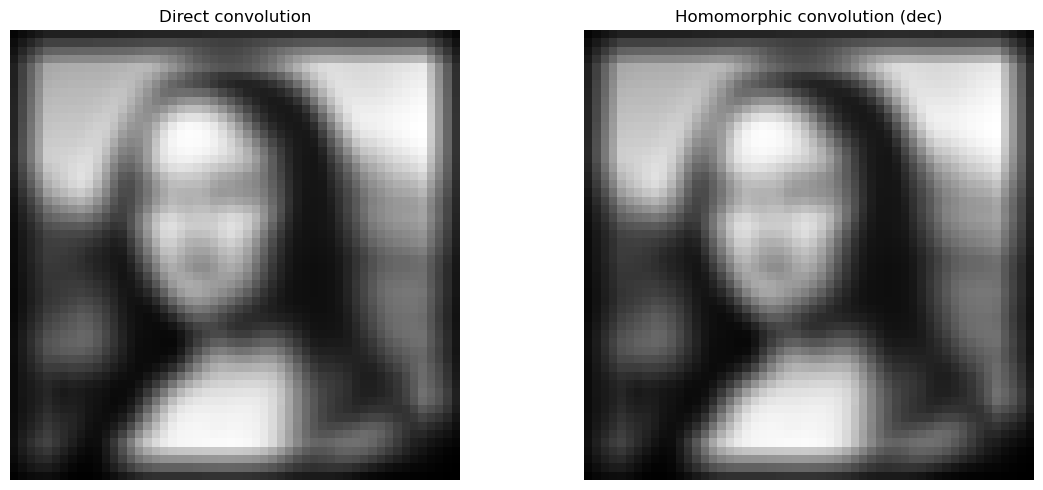

In [10]:
direct_conv = linear_convolution2d_direct(img_arr, flt)

# Drop tiny imaginary parts introduced by FFT‑based routines
direct_conv = np.real_if_close(direct_conv, tol=1e4)   # → float64
dec_conv    = np.real_if_close(dec_conv,    tol=1e4)   # already real, but safe

# Numerical check
print("Equality check (direct vs homomorphic):",
      np.allclose(dec_conv, direct_conv, atol=1e-1))

# Clip to [0,1] for nicer display (blur can cause slight undershoot/overshoot)
dir_disp = np.clip(direct_conv, 0, 1)
dec_disp = np.clip(dec_conv,    0, 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(dir_disp, cmap="gray")
plt.title("Direct convolution")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(dec_disp, cmap="gray")
plt.title("Homomorphic convolution (dec)")
plt.axis("off")

plt.tight_layout()
plt.show()


In [11]:
len(ct_conv[0].c0.coeffs)

512

In [12]:
ct_conv[0].c0.coeffs[0]

-200876504371529250815891970033251363419928320911350991703906

In [13]:
ct_conv[0].c0.coeffs[0] = ct_conv[0].c0.coeffs[0] + 1

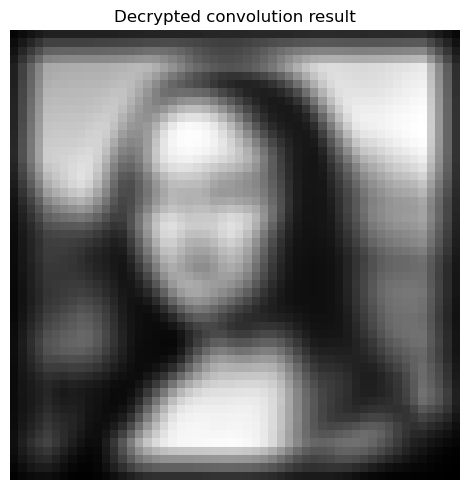

In [14]:
dec_conv = fcks.backward(ct_conv, target_height=out_h, target_width=out_w).real

plt.figure(figsize=(6, 5))
plt.imshow(np.clip(dec_conv, 0, 1), cmap="gray")
plt.title("Decrypted convolution result")
plt.axis("off")
plt.tight_layout()
plt.show()